In [1]:
from Program import Program, Instruction, CASES, MIN_LENGTH, MAX_LENGTH
import Selection
import random
import pickle
import math

In [2]:
def rand():
    """ Generates a Random Program """
    random_program = Program(IS=['Add', 'Sub', 'Mul', 'Div', 'Mean', 'Copy', 'Sqrt'])
    return random_program

def I(program, inp):
    """ Runs 'program' on input inp. Clips the return value to lie in [-1,1] as per the HW instructions """
    program.reset()
    program._set_input(inp)
    return_val = program.execute()
    # if return_val > 1:
    #     return 1
    # if return_val < -1:
    #     return -1
    return return_val

def f(program, gen, cases=CASES):
    """ Returns the sum of the squared error on the fitness cases for evaluating sin """
    F1_AMELIORATION = 2_500
    fitness = 0
    dif     = 0
    outs    = []
    fitness_1 = 0
    fitness_2 = 0
    out_counts = {}
    for i in range(len(cases)):
        tv = math.sin(cases[i])     #true value of sin for the fitness case
        rv = I(program, cases[i])   #return value of the program evaluated on the fitness case
        outs.append(rv) 
        fitness_1 += math.sqrt((rv-tv)**2)
        for out in outs:
            if out in out_counts.keys():
                out_counts[out] += 1
            else:
                out_counts[out] = 1
        for out_count in out_counts.keys():
            if out_counts[out_count] > 1:
                fitness_2 += out_counts[out_count]**2
    fitness = max([(1-(gen/F1_AMELIORATION)), 0])*fitness_2 + min([(gen/F1_AMELIORATION), 1])*fitness_1 
    return fitness

def f1(program, cases=CASES):
    F1_AMELIORATION = 2_500
    fitness = 0
    dif     = 0
    outs    = []
    fitness_1 = 0
    fitness_2 = 0
    out_counts = {}
    for i in range(len(cases)):
        tv = math.sin(cases[i])     #true value of sin for the fitness case
        rv = I(program, cases[i])   #return value of the program evaluated on the fitness case
        outs.append(rv) 
        fitness_1 += math.sqrt((rv-tv)**2)
    
    #     for out in outs:
    #         if out in out_counts.keys():
    #             out_counts[out] += 1
    #         else:
    #             out_counts[out] = 1
    #     for out_count in out_counts.keys():
    #         if out_counts[out_count] > 1:
    #             fitness_2 += out_counts[out_count]**2
    # fitness = max([(1-(gen/F1_AMELIORATION)), 0])*fitness_2 + min([(gen/F1_AMELIORATION), 1])*fitness_1 
    return fitness_1
    
    
def f2(program, generation=None, cases=CASES):
    F1_AMELIORATION = 2_500
    fitness = 0
    dif     = 0
    outs    = []
    fitness_1 = 0
    fitness_2 = 0
    out_counts = {}
    for i in range(len(cases)):
        #tv = math.sin(cases[i])     #true value of sin for the fitness case
        rv = I(program, cases[i])   #return value of the program evaluated on the fitness case
        outs.append(rv) 
        #fitness_1 += math.sqrt((rv-tv)**2)
    for out in outs:
        if out in out_counts.keys():
            out_counts[out] += 1
        else:
            out_counts[out] = 1
    for out_count in out_counts.keys():
        if out_counts[out_count] > 1:
            fitness_2 += out_counts[out_count]**2
    # fitness = max([(1-(gen/F1_AMELIORATION)), 0])*fitness_2 + min([(gen/F1_AMELIORATION), 1])*fitness_1 
    return fitness_2

def mut(program):
    #PROBABILITIES TO
    ADD_P = 0.0095   #Add a random instruction in a random location
    REM_P = 0.006   #Delete a random instruction
    NAM_P = 0.005   #Change the name of an instruction (and therefore its type)
    ARG_P = 0.005   #Change an argument of an instruction
    SWP_P = 0.005   #Swap two instructions
    
    if random.random() < ADD_P:  #Add instruction
        if (len(program.INST) < MAX_LENGTH):
            rand_inst = Instruction(len(program.WREG), len(program.CREG), instruction_set=program.IS)
            loc       = random.randint(0, len(program.INST))
            program.INST.insert(loc, rand_inst)
            
    if random.random() < REM_P:  #Remove instruction
        if (len(program.INST) > MIN_LENGTH):
            loc       = random.randint(0, len(program.INST)-1)
            program.INST.pop(loc)
            
    if random.random() < NAM_P:  #Change an instruction name
        if(len(program.INST) > 1):
            loc = random.randint(0, len(program.INST)-1)
            program.INST[loc]._set_name(random.choice(program.IS))
        
    if random.random() < ARG_P:   #Change argument to an instruction
        if(len(program.INST) > 1):
            inst_loc = random.randint(0, len(program.INST)-1)
            arg_loc  = random.randint(0,2)
            if arg_loc == 1:
                program.INST[inst_loc]._set_op1(random.randint(0, len(program.REG)))
            if arg_loc == 2:
                program.INST[inst_loc]._set_op2(random.randint(0, len(program.REG)))
            if arg_loc == 0:
                program.INST[inst_loc]._set_dest(random.randint(0, len(program.WREG)))
            
    if random.random() < SWP_P:   #Swap the index of two instructions
        if (len(program.INST) > 1):
            loc1 = random.randint(0, len(program.INST)-1)
            loc2 = random.randint(0, len(program.INST)-1)
            temp = program.INST[loc1]
            program.INST[loc1] = program.INST[loc2]
            program.INST[loc2] = temp
            
def XOver(prog1, prog2):
    """ Crossover Function chooses 2 random crossover points (one for each individual)
        Swaps the second part of program 2's instructions with the first part of program 1's instructions """
    #TODO: Make sure Xover cannot create programs that are too long!
    #Maybe determine the length of each program after loc1 and loc2 are selected and modify if one would be too long
    length_after_Xover_prog1 = MAX_LENGTH + 1
    length_after_Xover_prog2 = MAX_LENGTH + 1
    
    if ((len(prog1.INST) > 1) and (len(prog2.INST) > 1)):
        while(length_after_Xover_prog1 > MAX_LENGTH or length_after_Xover_prog2 > MAX_LENGTH):
            loc1 = random.randint(0, len(prog1.INST)-1)
            loc2 = random.randint(0, len(prog2.INST)-1)
            temp1 = prog1.INST[:loc1]
            temp2 = prog2.INST[loc2:]
            length_after_Xover_prog1 = len(temp2 + prog1.INST[loc1:])
            length_after_Xover_prog2 = len(prog2.INST[:loc2] + temp1)
        prog1.INST = temp2 + prog1.INST[loc1:]
        prog2.INST = prog2.INST[:loc2] + temp1
    

In [3]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
dataF = load_breast_cancer(as_frame=True)['data']
data  = load_breast_cancer()['data']
target = load_breast_cancer()['target']

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test1, y_train, y_test1 = train_test_split(data, target, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test       = train_test_split(X_test1, y_test1, test_size=0.5, random_state=42)

In [5]:
from sklearn.metrics import roc_auc_score
def f3(program, cases=X_train):
    outs = []
    for row in range(len(X_train)):
        tv = y_train[row]           #true value of sin for the fitness case
        #print(program)
        program.reset()             #return value of the program evaluated on the fitness case
        program._set_inputs(cases[row])
        #print(program)
        rv = program.execute()
        outs.append(rv) 
    if (max(outs) - min(outs) != 0):
        outs = [(float(i)-min(outs))/(max(outs)-min(outs)) for i in outs]
    elif max(outs) != 0:
        outs = [(float(i))/(max(outs)) for i in outs]
    fitness1 = roc_auc_score(y_train, outs)
        #fitness_1 += math.sqrt((rv-tv)**2)
    
    #     for out in outs:
    #         if out in out_counts.keys():
    #             out_counts[out] += 1
    #         else:
    #             out_counts[out] = 1
    #     for out_count in out_counts.keys():
    #         if out_counts[out_count] > 1:
    #             fitness_2 += out_counts[out_count]**2
    # fitness = max([(1-(gen/F1_AMELIORATION)), 0])*fitness_2 + min([(gen/F1_AMELIORATION), 1])*fitness_1 
    return fitness1

In [6]:
POP_SIZE       = 1000
XOVER_P        = 0.009
ELITE_K        = int(POP_SIZE*0.1)#50
population     = [Program(reg_init='z', IS=['Add', 'Sub', 'Mul', 'Div', 'Mean', 'Copy', 'Sqrt', 'Sin', 'Max', 'Min','Sqr', 'Exp', 'Log' ]) for i in range(POP_SIZE)] # Start with a population of 500 random programs
best_fitness_c = -1                   # Start this very high since even a random program will beat it
best_prog_c    = None                       # Keep track of the best program
tolerance      = 1                          # Stop searching when the best program has a fitness less than 1 (we want to minimize error)
generation     = 1

best_fitnesses_generation_c = []
avg_fitnesses_generation_c  = []

#TODO: Consider a fitness function that encourages putting DIFFERENT functions of the input in different registers. 10_000
#      is too big for a population and XOVER and mutation probabilities should be lowered.



logfile = open('log4.txt', 'w+')

while (generation < 100):
    if (generation % 100 < 10):
        dumpfile='./saved_generations/generation'+str(generation)+'.pkl'
        with open(dumpfile, 'wb+') as du:
            pickle.dump(population, du)
    print('Generation: ', generation)
    this_gen_fitness_c= []
    for individual in population:
        ind_fit = f3(individual)
        this_gen_fitness_c.append(ind_fit)
        if ind_fit > best_fitness_c:
            print('----------NEW BEST FITNESS---------------')
            print(ind_fit)
            print(individual)
            best_fitness_c = ind_fit
            best_prog_c    = individual
    best_fitnesses_generation_c.append(max(this_gen_fitness_c))
    avg_fitnesses_generation_c.append(sum(this_gen_fitness_c)/len(this_gen_fitness_c))
    logfile.write('-----------------GENERATION ' + str(generation) + '---------------------------\n')
    logfile.write("Fitnesses: [" + ", ".join(str(item) for item in this_gen_fitness_c) + "]\n")
    logfile.write('best fitness: ' +  str(best_fitnesses_generation_c[-1]) + "\n")
    logfile.write('avg fitnesses: ' +  str(avg_fitnesses_generation_c[-1]) + "\n")
    print('Best Fitness: ', best_fitnesses_generation_c[-1])
    print('Avg  Fitness: ', avg_fitnesses_generation_c[-1])
    elite = Selection.elite_selection(population, f3, X_train, k=int(POP_SIZE/10), opt_max=True)
    tournament = Selection.tournament_selection(population, f3, X_train, next_gen_size=int((POP_SIZE*8)/10), opt_max=True)
    randos     = [Program(reg_init='z', IS=['Add', 'Sub', 'Mul', 'Div', 'Mean', 'Copy', 'Sqrt', 'Sin', 'Max', 'Min','Sqr', 'Exp', 'Log' ]) for i in range(int(POP_SIZE/10))]
    # while(len(next_gen) < POP_SIZE-(POP_SIZE/10)): #Fill the next gen with tournament selection up to 90%
    #     r1 = random.randint(0, POP_SIZE-1)
    #     r2 = random.randint(0, POP_SIZE-1)
    #     if this_gen_fitness[r1] < this_gen_fitness[r2]:
    #         next_gen.append(population[r1]._clone())
    #     else:
    #         next_gen.append(population[r2]._clone())
            
    # while(len(next_gen) < POP_SIZE):              #Fill the rest of the population with random programs
    #     next_gen.append(Program(reg_init='z'))
    next_gen=elite+tournament+randos
    for program in range(len(next_gen)):
        mut(next_gen[program])
        if random.random() < XOVER_P:
            program2 = random.randint(0, len(next_gen)-1)
            XOver(next_gen[program], next_gen[program2])
            logfile.write('Crossed ' + str(program) + ' and ' + str(program2) +'\n')
    generation += 1
    population = next_gen
    for program in population:
        program.reset()
    
            
logfile.close()

Generation:  1
----------NEW BEST FITNESS---------------
0.5
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09090909090909091, 0.0, 1.3956124250860895, 0.0, -2.0, -1.0, 1.0, 0.5, 0.3333333333333333, 0.25, 0.2, 12.18, 20.52, 77.22, 458.7, 0.08013, 0.04038, 0.02383, 0.0177, 0.1739, 0.05677, 0.1924, 1.571, 1.183, 14.68, 0.00508, 0.006098, 0.01069, 0.006797, 0.01447, 0.001532, 13.34, 32.84, 84.58, 547.8, 0.1123, 0.08862, 0.1145, 0.07431, 0.2694, 0.06878]
Exp(19,24,11)
Sub(10,10,18)
Mean(17,17,23)
Mean(23,18,8)
Sub(11,7,6)
Exp(27,19,21)
Mean(8,18,19)
Sqrt(12,11,20)
Min(20,21,3)
Div(30,22,22)
Div(24,26,23)
Log(17,15,18)
Sqr(24,9,8)
Max(7,19,0)
Sqrt(6,6,12)
Copy(4,20,17)
Div(20,11,5)

----------NEW BEST FITNESS---------------
0.929273389332561
[-4.153151630887583, 1.0, 1.0, 24.36, 0.0, 4.935585071701226, -0.25, 0.0, -0.8414709848078965, 24.36, 0.0, 0.4112987559751021, -4.153151630887583, 4.153151630887583, 0.0, 0.0, 17.248668469144192, 1.6161

In [8]:
best_prog_c

[-4.153151630887583, 1.0, 1.0, 24.36, 0.0, 4.935585071701226, -0.25, 0.0, -0.8414709848078965, 24.36, 0.0, 0.4112987559751021, -4.153151630887583, 4.153151630887583, 0.0, 0.0, 17.248668469144192, 1.6161982319408212, 0.0, 0.0, 0.6635116636975381, 4.935585071701226, 0.0, 0.0, -1.0, 1.0, 0.5, 0.3333333333333333, 0.25, 0.2, 12.18, 20.52, 77.22, 458.7, 0.08013, 0.04038, 0.02383, 0.0177, 0.1739, 0.05677, 0.1924, 1.571, 1.183, 14.68, 0.00508, 0.006098, 0.01069, 0.006797, 0.01447, 0.001532, 13.34, 32.84, 84.58, 547.8, 0.1123, 0.08862, 0.1145, 0.07431, 0.2694, 0.06878]
Add(10,6,19)
Min(18,14,10)
Max(19,19,4)
Mean(6,2,18)
Sqrt(4,18,7)
Div(19,7,11)
Exp(3,4,13)
Sub(7,28,17)
Mean(2,13,20)
Add(13,9,6)
Copy(8,12,19)
Sub(26,21,8)
Log(13,6,23)
Sqrt(13,4,1)
Exp(19,25,2)
Sin(19,0,15)
Mean(15,15,11)
Copy(14,19,14)
Sqrt(12,16,11)
Div(30,8,9)
Sqrt(9,8,21)
Mul(21,20,11)
Min(23,1,6)
Exp(14,12,5)
Mean(3,30,17)
Sin(24,6,8)
Max(9,19,3)
Mul(8,21,13)
Min(25,10,0)
Sqrt(15,7,13)
Mean(12,21,20)
Max(23,13,5)
Exp(16,29

In [9]:
program=best_prog_c
outs = []
for row in range(len(X_test)):
    tv = y_test[row]           #true value of sin for the fitness case
    #print(program)
    program.reset()             #return value of the program evaluated on the fitness case
    program._set_inputs(X_test[row])
    #print(program)
    rv = program.execute()
    outs.append(rv) 
if (max(outs) - min(outs) != 0):
    outs = [(float(i)-min(outs))/(max(outs)-min(outs)) for i in outs]
elif max(outs) != 0:
    outs = [(float(i))/(max(outs)) for i in outs]
fitness_c = roc_auc_score(y_test, outs)
fitness_c
    #fitness_1 += math.sqrt((rv-tv)**2)

#     for out in outs:
#         if out in out_counts.keys():
#             out_counts[out] += 1
#         else:
#             out_counts[out] = 1
#     for out_count in out_counts.keys():
#         if out_counts[out_count] > 1:
#             fitness_2 += out_counts[out_count]**2
# fitness = max([(1-(gen/F1_AMELIORATION)), 0])*fitness_2 + min([(gen/F1_AMELIORATION), 1])*fitness_1 


0.9878048780487805

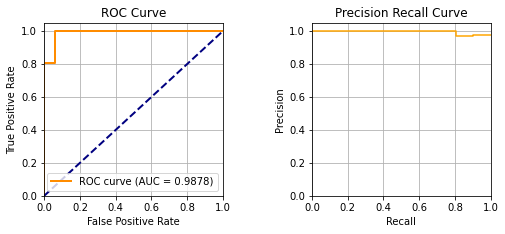

In [14]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
def plot_roc_and_precision_recall(y_true, y_score):
    #Method from https://colab.research.google.com/github/gal-a/blog/blob/master/docs/notebooks/sklearn/sklearn_logistic_regression_vs_gbm.ipynb#scrollTo=-aBbV0bWBxwc
    # Get ROC curve FPR and TPR from true labels vs score values
    fpr, tpr, _ = roc_curve(y_true, y_score)

    # Calculate ROC Area Under the Curve (AUC) from FPR and TPR data points
    roc_auc = auc(fpr, tpr)

    # Calculate precision and recall from true labels vs score values
    precision, recall, _ = precision_recall_curve(y_true, y_score)

    plt.figure(figsize=(8, 3))

    plt.subplot(1,2,1)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.step(recall, precision, color='orange', where='post')
    # plt.fill_between(recall, precision, step='post', alpha=0.5, color='orange')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision Recall Curve')
    plt.grid(True)

    left  = 0.125  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom part of the subplots of the figure
    top = 0.9      # the top part of the subplots of the figure
    wspace = 0.5   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots
    plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
    plt.show()

    

plot_roc_and_precision_recall(y_test, outs)  # provide the column for the scores belonging only to the positive class
print()

In [15]:
2.0 and 3.0

3.0

In [16]:
3 < 4

True

In [17]:
float(3 < 4)

1.0